# Multiproduct Linear Monopolist

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from math import sqrt, ceil
from timeit import default_timer as timer
from datetime import timedelta
import sys
sys.path.append('..')
from modules import LinearMonopolist

## Setting 1

In [2]:
### Types setting
c = 0.01
n0, n1 = 10, 10
theta0, theta1 =  np.linspace(c, c+1, num=n0, dtype=np.float32), np.linspace(c, c+1, num=n1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1]     # number of types

f = np.ones(N, dtype=np.float32).flatten()    # weights of the distribution

### Objects
model = LinearMonopolist(theta, f)

model id = LinearMonopolist_N100_2024-02-06_21-43-10



## Direct resolution (with all the constraints)

convergence = True, iterations = 1897, elapsed time = 0:00:04.120107
primal residual = 8.59e-01 tol, dual residual = 7.73e-01 tol
primal-dual gap = 1.12e-03, optimal value - current value < 1.87e-05 optimal value


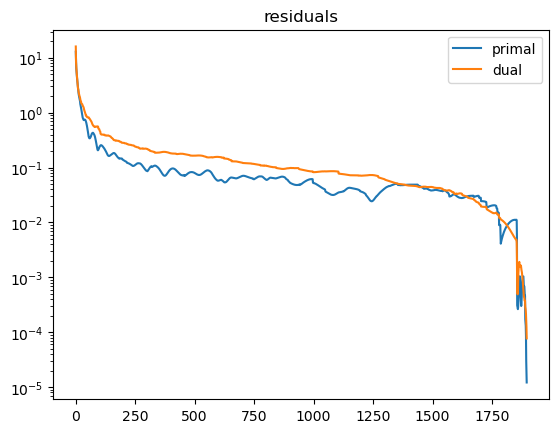

In [8]:
model.all()
model.solve(stepratio=1, it_max=1e4, tol_primal=1e-6, tol_dual=1e-6, scale=True,) #path='results/'+model.id
model.residuals(title='residuals')

In [6]:
atol = 1e-6
y0_0 = np.isclose(model.y[:model.N],0, atol=atol)
y0_1 = np.isclose(model.y[:model.N],1, atol=atol, rtol=0)
y1_0 = np.isclose(model.y[model.N:],0, atol=atol)
y1_1 = np.isclose(model.y[model.N:],1, atol=atol, rtol=0)

y_00 = np.flatnonzero(np.logical_and(y0_0, y1_0))
y_01 = np.flatnonzero(np.logical_and(y0_0, y1_1))
y_10 = np.flatnonzero(np.logical_and(y0_1, y1_0))
y_11 = np.flatnonzero(np.logical_and(y0_1, y1_1))

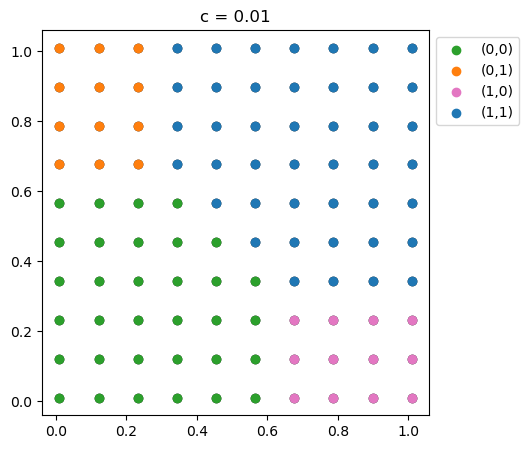

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
_ = ax.scatter(theta[0], theta[1], facecolors='w',edgecolors='k')
_ = ax.scatter(theta[0, y_00], theta[1, y_00], c='tab:green', label='(0,0)')
_ = ax.scatter(theta[0, y_01], theta[1, y_01], c='tab:orange', label='(0,1)')
_ = ax.scatter(theta[0, y_10], theta[1, y_10], c='tab:pink', label='(1,0)')
_ = ax.scatter(theta[0, y_11], theta[1, y_11], c='tab:blue', label='(1,1)')
_ = ax.legend(bbox_to_anchor=(1, 1),loc='upper left') #bbox_to_anchor=(0., -.13, 1., .1), loc='lower left', ncols=4, mode="expand", borderaxespad=0.) #(bbox_to_anchor=(1.02, 1.), loc='lower right')
_ = ax.set_title(f'c = {c}')

In [345]:
path = 'results/'+model.id
fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

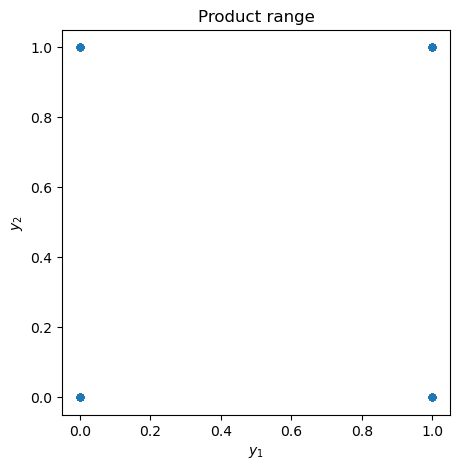

In [321]:
model.range(title='Product range', ) #path='results/'+model.id+'_products')
# model.constraints(path='results/'+model.id+'_constraints')

## Setting 2

In [21]:
### Types setting
c = 0.05
n0, n1 = 100, 100
theta0, theta1 =  np.linspace(c, c+1, num=n0, dtype=np.float32), np.linspace(c, c+1, num=n1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1]     # number of types

f = np.ones(N, dtype=np.float32).flatten()    # weights of the distribution

### Objects
model = LinearMonopolist(theta, f)

model id = LinearMonopolist_N10000_2024-02-06_22-00-11



## Adaptative approach (starting with the local constraints)

In [22]:
kmax = ceil(sqrt(N))+1
t_start = timer()
model.local(); k = 0; test = np.array([False,False])
while np.all(test==False):
    k += 1
    print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
    model.solve(warmstart=True, it_max = 1e4, stepratio=1,) # path='results/'+model.id) #sqrt(len(model.indices)) #len(model.indices)
    # model.residuals()
    print(f'IC constraints: {len(model.IC_binding)} binding, {len(model.IC_violated)} violated\n')
    # model.indices = sorted(set(model.indices).union(model.IC_violated))
    model.indices = sorted(set(model.indices).union(set(model.IC_violated).intersection(model.ind_local(k*ceil(sqrt(N))))))
    model.local(model.indices)
    test = np.array([k==kmax, len(model.IC_violated)==0])
elapsed = timer() - t_start
print(f'elapsed time = {str(timedelta(seconds=elapsed))}')

OPTIMIZATION 1: 19800 IC constraints
convergence = True, iterations = 311, elapsed time = 0:01:07.665103
primal residual = 3.97e-01 tol, dual residual = 3.99e-01 tol
primal-dual gap = -4.67e-03, optimal value - current value < -7.58e-07 optimal value
IC constraints: 19800 binding, 3414600 violated

OPTIMIZATION 2: 69155 IC constraints


In [12]:
atol = 1e-6
y0_0 = np.isclose(model.y[:model.N],0, atol=atol)
y0_1 = np.isclose(model.y[:model.N],1, atol=atol, rtol=0)
y1_0 = np.isclose(model.y[model.N:],0, atol=atol)
y1_1 = np.isclose(model.y[model.N:],1, atol=atol, rtol=0)

y_00 = np.flatnonzero(np.logical_and(y0_0, y1_0))
y_01 = np.flatnonzero(np.logical_and(y0_0, y1_1))
y_10 = np.flatnonzero(np.logical_and(y0_1, y1_0))
y_11 = np.flatnonzero(np.logical_and(y0_1, y1_1))
# y_else = np.flatnonzero(np.logical_or(np.logical_and(~y0_0, ~y0_1), np.logical_and(~y1_0, ~y1_1)))

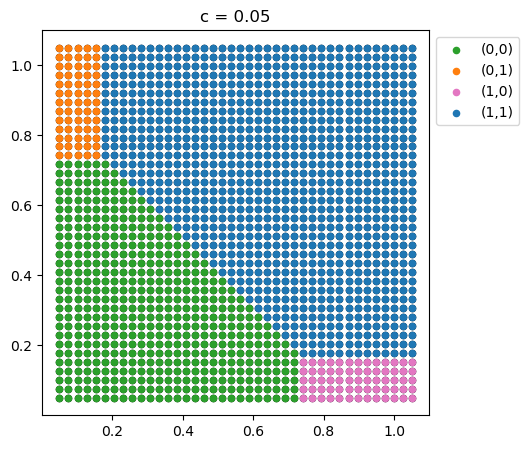

In [16]:
import matplotlib.pyplot as plt
s = 20
fig, ax = plt.subplots(figsize=(5,5))
_ = ax.scatter(theta[0], theta[1], s=s, facecolors='w',edgecolors='k')
_ = ax.scatter(theta[0, y_00], theta[1, y_00], s=s, c='tab:green', label='(0,0)')
_ = ax.scatter(theta[0, y_01], theta[1, y_01], s=s, c='tab:orange', label='(0,1)')
_ = ax.scatter(theta[0, y_10], theta[1, y_10], s=s, c='tab:pink', label='(1,0)')
_ = ax.scatter(theta[0, y_11], theta[1, y_11], s=s, c='tab:blue', label='(1,1)')
# _ = ax.scatter(theta[0, y_else], theta[1, y_else], s=s, c='tab:red', label='else')
_ = ax.legend(bbox_to_anchor=(1, 1),loc='upper left') #bbox_to_anchor=(0., -.13, 1., .1), loc='lower left', ncols=4, mode="expand", borderaxespad=0.) #(bbox_to_anchor=(1.02, 1.), loc='lower right')
_ = ax.set_title(f'c = {c}')

In [17]:
path = 'results/'+model.id
fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

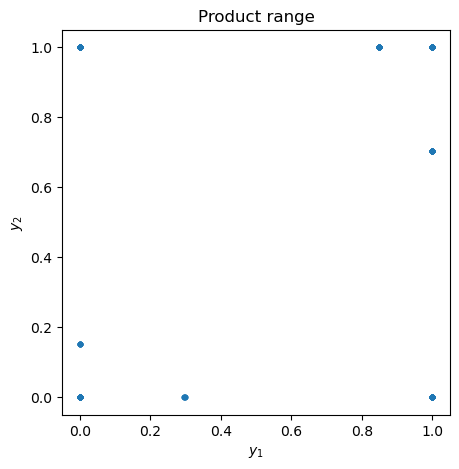

In [404]:
model.range(title='Product range', s=10,) #path='results/'+model.id)
# model.constraints()